Welcome to Predict Future Sales Challenge. In this kernel, I will focus on doing some illustrative data visualizations and then use LSTM to predict November 2015's sale 

# Loading Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

%matplotlib inline

train = pd.read_csv('../dataset/sales_train_v2.csv')
test = pd.read_csv('../dataset/test.csv')
submission = pd.read_csv('../dataset/sample_submission.csv')
items = pd.read_csv('../dataset/items.csv')
item_cats = pd.read_csv('../dataset/item_categories.csv')
shops = pd.read_csv('../dataset/shops.csv')

C:\Users\charlychiu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First we will check if all shop and items in the test set is also in the training set.

In [2]:
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

In [3]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

# Data Exploration
Next, we would like to gain some insights about the data. I will attack from two angles, shop and item categories.

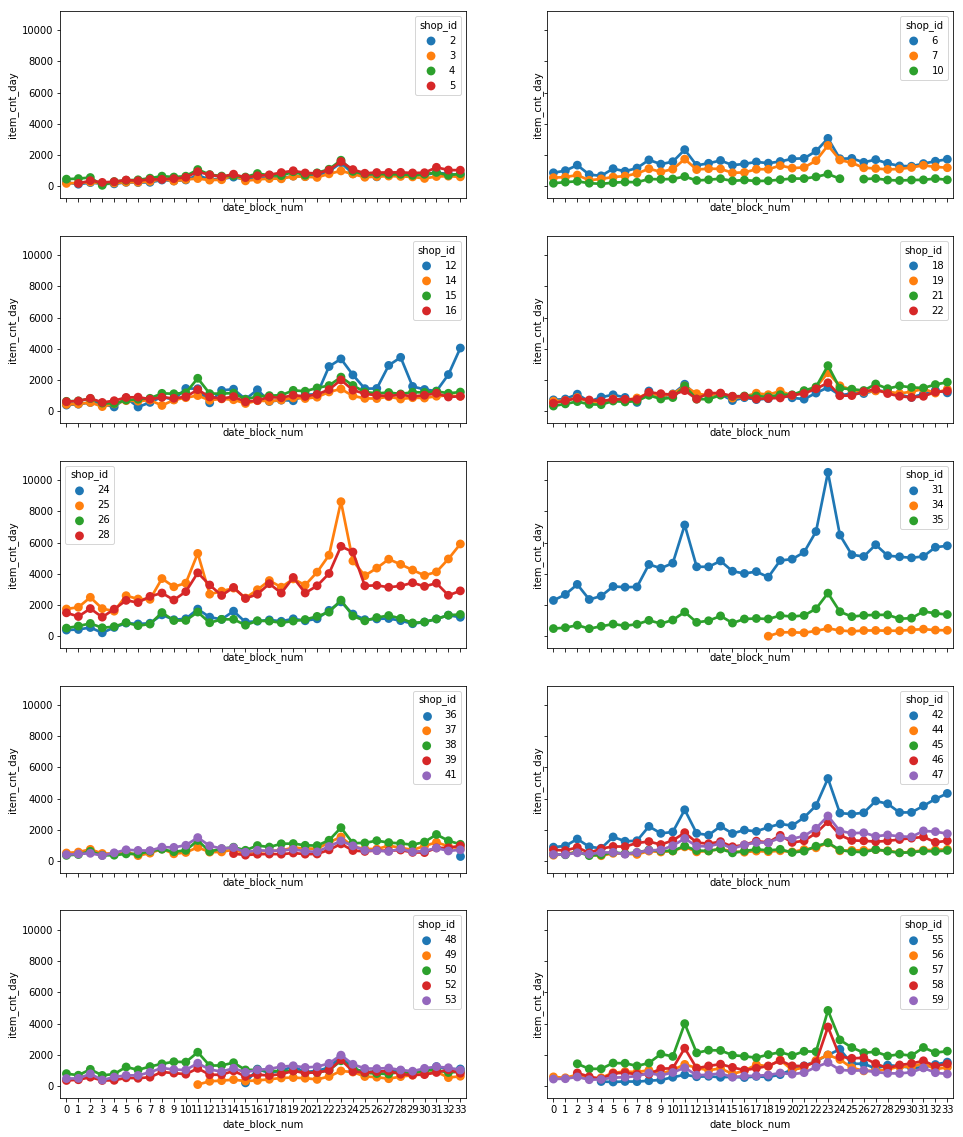

In [4]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

Clearly, there is a peak in shop shop at the end of the year, probably due to the holiday season. Therefore, it would be beneficial to add month and year, so that the network can pickup this pattern. It would be nice to see how each item sale is going. However, given the number of items, it would be more beneficial if we look at how each item categories is doing instead.

In [5]:
# add categories
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [6]:
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

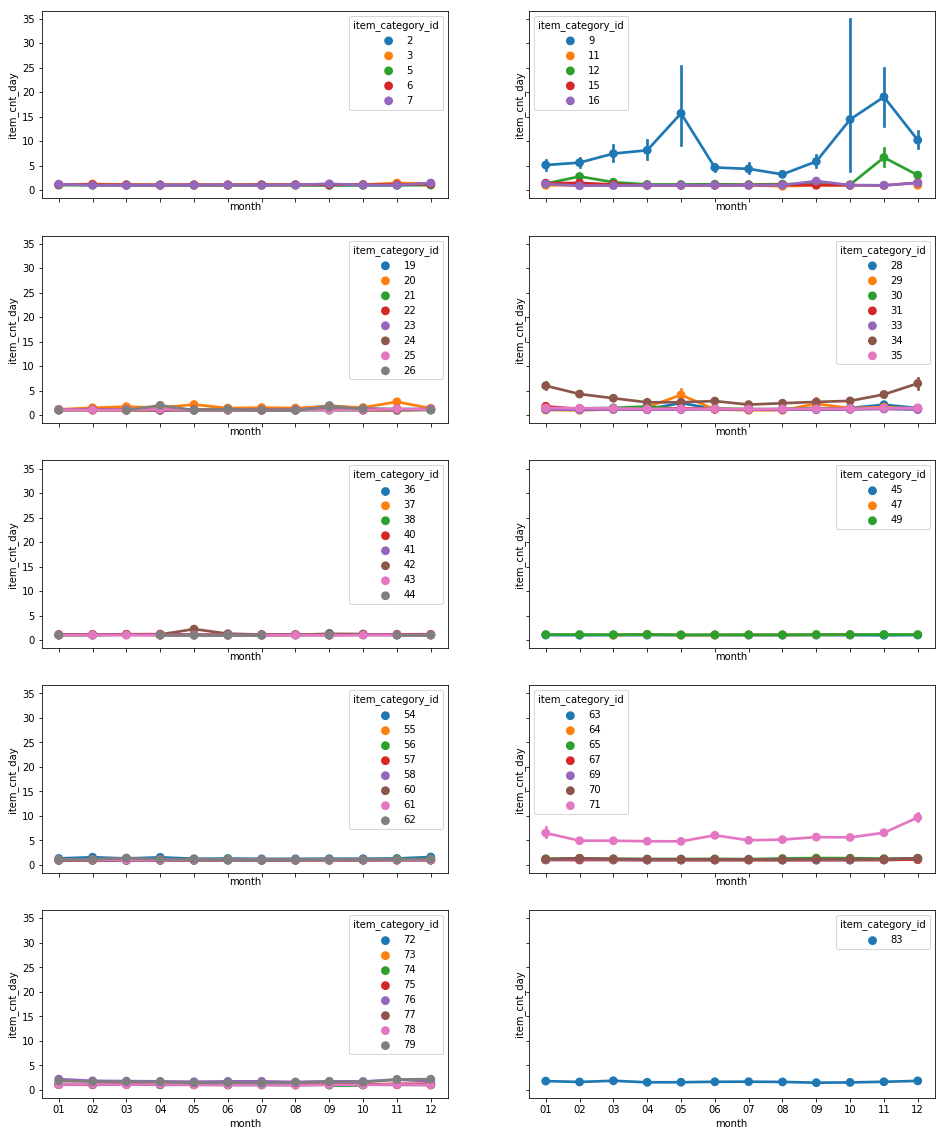

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

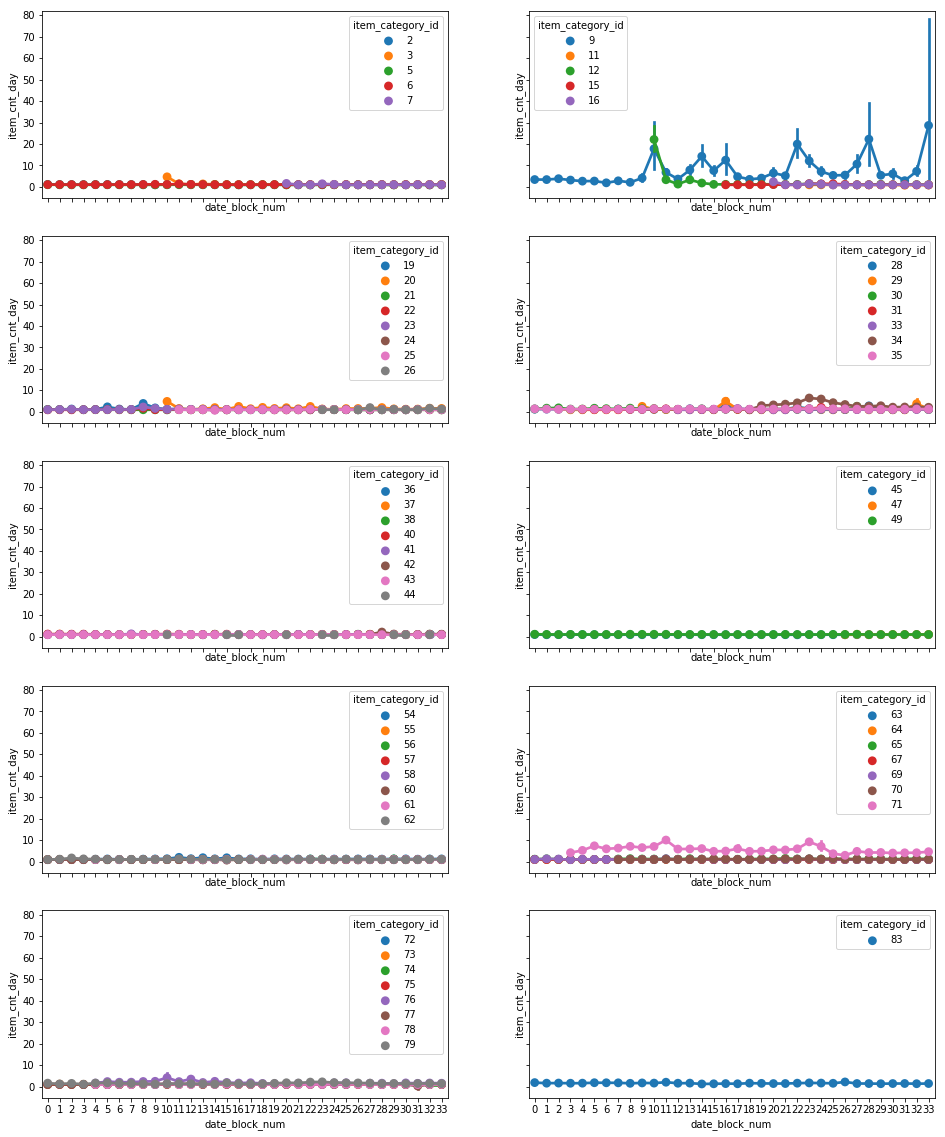

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

In [9]:
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()

# Training
In gradient based learning method, it is common to normalize the numerical variable to speed up the training

In [10]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train.item_price.as_matrix().reshape(-1, 1))
cnt_scaler.fit(train.item_cnt_day.as_matrix().reshape(-1, 1))

train.item_price = scaler.transform(train.item_price.as_matrix().reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.as_matrix().reshape(-1, 1))

C:\Users\charlychiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\charlychiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\charlychiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\charlychiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


It is natural to try to encode the whole training set to feed to the network. However, this approach has two drawbacks:
- It is unlikely that sale data from Jan 2013 or any time close by has any effect with sale of Nov 2015.
- The memory requirements exceed the limit that Kaggle provides.

We would instead learn the sequence of July, August, September, October, November in 2013 and 2014. 

## Missing data
Not every item is saled in the above time period, we will add a record for them with `item_cnt_day` as 0. The `price` is a little bit tricky. As can be seen at the code below, price of an item depends on shop and point of time. We will fill in empty values with the closest past record.

In [11]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

item_price  item_cnt_day
item_id date_block_num shop_id                          
30      1              3         -0.072265      0.115543
                       4          0.041532      0.381274
                       5         -0.072265      0.204120
                       6          0.314142      2.241392
                       7          0.149626      0.647005
                       10        -0.186490      0.115543
                       12        -0.242961     -0.150189
                       14         0.149626      0.469851
                       15         0.208426      1.178467
                       16         0.097005      1.178467
                       18        -0.072265      0.292697
                       19         0.152478      1.089890
                       21         0.098431      0.912736
                       22         0.041532      0.558428
                       24         0.326026      1.089890
                       25         0.439823      4.012933
                       26         0.316329      1.709929
                       28         0.661704      4.987280
                       31         0.665965      9.681864
                       35         0.142971      1.178467
                       37         0.212228      1.089890
                       38         0.098431      0.469851
                       41        -0.186062     -0.061612
                       42         0.548283      3.835779
                       44         0.269127      1.355621
                       45        -0.015366      0.292697
                       46         0.382925      1.621352
                       47         0.089854      0.647005
                       50         0.494821      2.329969
                       52        -0.129164      0.204120
...                                    ...           ...
22167   30             52        -0.214583     -0.061612
        31             2         -0.257221     -0.150189
                       12        -0.129306      0.115543
                       22         0.041247      0.912736
                       25        -0.214583     -0.061612
                       26        -0.257221     -0.150189
                       31        -0.257221     -0.150189
                       35        -0.257221     -0.150189
                       39        -0.257221     -0.150189
                       42        -0.171945      0.026965
                       52        -0.214583     -0.061612
        32             12        -0.044030      0.292697
                       21        -0.214583     -0.061612
                       22        -0.129306      0.115543
                       24        -0.257221     -0.150189
                       25        -0.129306      0.115543
                       42        -0.171945      0.115543
        33             6         -0.257221     -0.150189
                       10        -0.277756     -0.150189
                       12        -0.001391      0.381274
                       18        -0.257221     -0.150189
                       21        -0.257221     -0.150189
                       22         0.162767      1.001313
                       25        -0.214583      0.026965
                       26        -0.257221     -0.150189
                       28        -0.257221     -0.150189
                       37        -0.257221     -0.150189
                       42        -0.171945      0.115543
                       47        -0.257221     -0.150189
                       50        -0.257221     -0.150189

[600159 rows x 2 columns]

For easier grouping, I would change the grouping order a little

In [12]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

I would then define some helper functions

In [13]:
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [14]:
assert closest_date_block(18, 30, 5) == 18

In [15]:
# Some simple math to know what date_block_num to start learning
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


We will do some simple math to find out what block should we train on

In [16]:
maxlen = 4 # 4 months
step = 1
# 0: train, 1: val, 2:test
sentences = [[],[],[]]
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)            
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

In [17]:
x_train_o = np.array(sentences[0])
x_val_o = np.array(sentences[1])
x_test_o = np.array(sentences[2])
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])

In [18]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1

Next, we would transform categorical value to their one-hot encoding version

In [19]:
from sklearn import preprocessing

shop_le = preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm = dict(zip(test_shops, shop_le.transform(test_shops)))

item_le = preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm = dict(zip(test_items, item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()
month_le.fit(range(7,11))
month_dm = dict(zip(range(7,11), month_le.transform(range(7,11))))

#cat_le = preprocessing.LabelEncoder()
#cat_le.fit(item_cats.item_category_id)
#cat_dm = dict(zip(item_cats.item_category_id.unique(), cat_le.transform(item_cats.item_category_id.unique())))

In [20]:
def vectorize(inp):
    print('Vectorization...')   
    x = np.zeros((len(inp), maxlen, length), dtype=np.float32)
    for i, sentence in enumerate(inp):
        for t, char in enumerate(sentence):            
            x[i][t][ shop_dm[char['shop_id']] ] = 1        
            x[i][t][ MAX_SHOP + item_dm[char['item_id']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + month_dm[char['month']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 ] = char['item_price']
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1] = char['item_cnt_day']    
    return x

In [22]:
x_train = vectorize(x_train_o)
x_val = vectorize(x_val_o)
x_test = vectorize(x_test_o)

Vectorization...


MemoryError: 

In [ ]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(32, input_shape=(maxlen, length)))
model.add(Dense(1, activation='relu'))

optimizer = RMSprop(lr=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(x_train, y_train, batch_size=128, epochs=13)

Below is the evaluation code for the model. For the speed of the kernel, I have commented them, but you can still find the result at the end of the cell

In [ ]:
#import math
#from sklearn.metrics import mean_squared_error

# make predictions
#predict_train = model.predict(x_train)
#predict_val = model.predict(x_val)
# invert predictions
#predict_train = cnt_scaler.inverse_transform(predict_train)
#y_train = cnt_scaler.inverse_transform(y_train)
#predict_val = cnt_scaler.inverse_transform(predict_val)
#y_val = cnt_scaler.inverse_transform(y_val)
# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(predict_train, y_train))
#print('Train Score: %.2f RMSE' % (trainScore))
#valScore = math.sqrt(mean_squared_error(predict_val, y_val))
#print('Test Score: %.2f RMSE' % (valScore))
#For 1 epoch
#Train Score: 3.85 RMSE
#Test Score: 4.29 RMSE

The learning seems to converge. We will then incrementally train on the validation set ([why does it work](https://github.com/keras-team/keras/issues/4446#issuecomment-261804574))

In [ ]:
model.fit(x_val, y_val, batch_size=128, epochs=13)

# Inference
With everything prepared, let's moved to the inference part

In [ ]:
predict_test = model.predict(x_test)
predict_test = cnt_scaler.inverse_transform(predict_test)

In [ ]:
test = test.set_index(['shop_id', 'item_id'])
test['item_cnt_month'] = 0

In [ ]:
for index, sentence in enumerate(x_test_o):
    (shop_id, item_id) = (sentence[0]['shop_id'], sentence[0]['item_id'])
    test.loc[(shop_id, item_id)]['item_cnt_month'] = predict_test[index]

In [ ]:
test = test.reset_index().drop(['shop_id', 'item_id'], axis=1)
test.to_csv('submission.csv', index=False)